# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

### Найти данные в виде изображений для задачи классификации.

Используем датасет MNIST


In [29]:
import warnings

import sns

warnings.filterwarnings('ignore')

In [30]:
from matplotlib import pyplot as plt
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

train_set = MNIST(root=".", download=True, train=True, transform=ToTensor())

torch_generator = torch.Generator().manual_seed(42)
train_set, val_set = torch.utils.data.random_split(
    train_set,
    [int(len(train_set) * 0.8), len(train_set) - int(len(train_set) * 0.8)],
    torch_generator,
)
test_set = MNIST(root=".", download=True, train=False, transform=ToTensor())

### Реализовать классы, необходимые для построения сети с Batch normalization.

In [31]:
from torch import nn
from torch.nn import functional as F

class MyLinearFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inp, w, b):
        out = inp @ w + b
        ctx.save_for_backward(inp, w)
        return out

    @staticmethod
    def backward(ctx, grad_out):
        inp, w = ctx.saved_tensors
        grad_inp = grad_out @ w.T
        grad_w = grad_out.T @ inp
        grad_b = grad_out.sum(dim=0)
        return grad_inp, grad_w.T, grad_b


class FullyConnectedLayer(nn.Module):
    def __init__(self, in_dim, out_dim, dtype=torch.float):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((in_dim, out_dim), dtype=dtype))
        self.bias = nn.Parameter(torch.empty(out_dim, dtype=dtype))
        self._init_weights()

    def forward(self, x):
        return MyLinearFunc.apply(x, self.weight, self.bias)

    def _init_weights(self):
        nn.init.kaiming_normal_(self.weight, mode="fan_out", nonlinearity="relu")
        nn.init.uniform_(self.bias, -0.5, 0.5)


class ReluLayer(nn.Module):
    def forward(self, x):
        return F.relu(x)

In [32]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, hidden_size=256, batch_normalization=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_normalization = batch_normalization
        self.input_layer = FullyConnectedLayer(28 * 28, hidden_size)
        self.relu = ReluLayer()
        self.output_layer = FullyConnectedLayer(hidden_size, 10)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        if self.batch_normalization:
            x = self.batch_norm(x)
        x = self.output_layer(x)
        return x

In [33]:
import pytorch_lightning as L

class CustomLitModule(L.LightningModule):
    def __init__(self, hidden_dim, use_bn, optimizer_cls, lr, weight_decay):
        super().__init__()
        self.net = MyNeuralNetwork(hidden_size=hidden_dim, batch_normalization=use_bn)
        self._optimizer_cls = optimizer_cls
        self._lr = lr
        self._wd = weight_decay

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        inputs = inputs.flatten(start_dim=1)
        out = self.net(inputs)
        loss = nn.functional.cross_entropy(out, targets)
        self.log("train_loss", float(loss), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        inputs = inputs.flatten(start_dim=1)
        out = self.net(inputs)
        val_loss = nn.functional.cross_entropy(out, targets)
        preds = out.argmax(dim=1)
        val_acc = (preds == targets).float().mean().item()
        self.log_dict({"val_loss": float(val_loss), "val_acc": val_acc})

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        inputs = inputs.flatten(start_dim=1)
        out = self.net(inputs)
        preds = out.argmax(dim=1)
        test_acc = (preds == targets).float().mean().item()
        self.log("test_acc", test_acc)

    def configure_optimizers(self):
        return self._optimizer_cls(
            self.net.parameters(), lr=self._lr, weight_decay=self._wd
        )

### Реализовать оптимизатор Adam.

In [34]:
from torch.optim.optimizer import Optimizer

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        self.state = {}
        for group in self.param_groups:
            for p in group["params"]:
                self.state[p] = {
                    "step": 0,
                    "exp_avg": torch.zeros_like(p),
                    "exp_avg_sq": torch.zeros_like(p)
                }

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            b1, b2 = group["betas"]
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if group["weight_decay"] != 0:
                    grad = grad + group["weight_decay"] * p.data

                st = self.state[p]
                st["step"] += 1

                st["exp_avg"] = b1 * st["exp_avg"] + (1 - b1) * grad
                st["exp_avg_sq"] = b2 * st["exp_avg_sq"] + (1 - b2) * grad * grad

                bias_correction1 = 1 - b1 ** st["step"]
                bias_correction2 = 1 - b2 ** st["step"]

                step_size = group["lr"] * (bias_correction2 ** 0.5) / bias_correction1

                p.data -= step_size * st["exp_avg"] / (torch.sqrt(st["exp_avg_sq"]) + group["eps"])

        return loss

### Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.

In [ ]:
import pandas as pd

# оптимизаторы
optimizers = [
    ("SGD", torch.optim.SGD),
    ("Adam", Adam),
    ("RMSprop", torch.optim.RMSprop),
]

# гиперпараметры
lrs = [1e-2, 1e-3]
hidden_sizes = [100, 1000]
use_batch_norm_options = [False, True]
batch_size = 4096
max_epochs = 2
weight_decay = 0.005

# DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=0
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=0
)

# Таблица для результатов
results = []

for opt_name, opt_cls in optimizers:
    for lr in lrs:
        for hidden_size in hidden_sizes:
            for use_bn in use_batch_norm_options:
                tag = f"{opt_name}_lr{lr}_hid{hidden_size}_bn{use_bn}"
                print("=== START", tag)

                model = CustomLitModule(
                    hidden_dim=hidden_size,
                    use_bn=use_bn,
                    optimizer_cls=opt_cls,
                    lr=lr,
                    weight_decay=weight_decay,
                )

                trainer = L.Trainer(
                    max_epochs=max_epochs,
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    devices=1,
                    log_every_n_steps=5,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                )

                # обучение
                trainer.fit(model, train_loader, val_loader)

                # вал и тест
                val_metrics = trainer.validate(model, val_loader, verbose=False)
                test_metrics = trainer.test(model, test_loader, verbose=False)

                val_loss = val_metrics[0].get("val_loss", None)
                val_acc = val_metrics[0].get("val_acc", None)
                test_acc = test_metrics[0].get("test_acc", None)

                results.append({
                    "optimizer": opt_name,
                    "lr": lr,
                    "hidden_size": hidden_size,
                    "use_batch_norm": use_bn,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "test_acc": test_acc,
                })

                print("=== DONE", tag)

# Формируем DataFrame
df = pd.DataFrame(results)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== START SGD_lr0.01_hid100_bnFalse


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.01_hid100_bnFalse
=== START SGD_lr0.01_hid100_bnTrue


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.01_hid100_bnTrue
=== START SGD_lr0.01_hid1000_bnFalse


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.01_hid1000_bnFalse
=== START SGD_lr0.01_hid1000_bnTrue


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.01_hid1000_bnTrue
=== START SGD_lr0.001_hid100_bnFalse


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.001_hid100_bnFalse
=== START SGD_lr0.001_hid100_bnTrue


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.001_hid100_bnTrue
=== START SGD_lr0.001_hid1000_bnFalse


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.001_hid1000_bnFalse
=== START SGD_lr0.001_hid1000_bnTrue


`Trainer.fit` stopped: `max_epochs=2` reached.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


=== DONE SGD_lr0.001_hid1000_bnTrue
=== START Adam_lr0.01_hid100_bnFalse


### Анализ, результаты и итог

In [23]:
print(df)

   optimizer     lr  hidden_size  use_batch_norm  val_loss   val_acc  test_acc
0        SGD  0.010          100           False  2.212954  0.196583    0.2012
1        SGD  0.010          100            True  1.398188  0.599750    0.6043
2        SGD  0.010         1000           False  1.952302  0.445250    0.4480
3        SGD  0.010         1000            True  1.074861  0.720583    0.7339
4        SGD  0.001          100           False  2.541445  0.108833    0.1078
5        SGD  0.001          100            True  2.426551  0.152750    0.1523
6        SGD  0.001         1000           False  2.334715  0.127583    0.1337
7        SGD  0.001         1000            True  2.183827  0.250333    0.2613
8       Adam  0.010          100           False  0.319943  0.907417    0.9160
9       Adam  0.010          100            True  0.289617  0.917000    0.9259
10      Adam  0.010         1000           False  0.340269  0.897667    0.9093
11      Adam  0.010         1000            True  0.

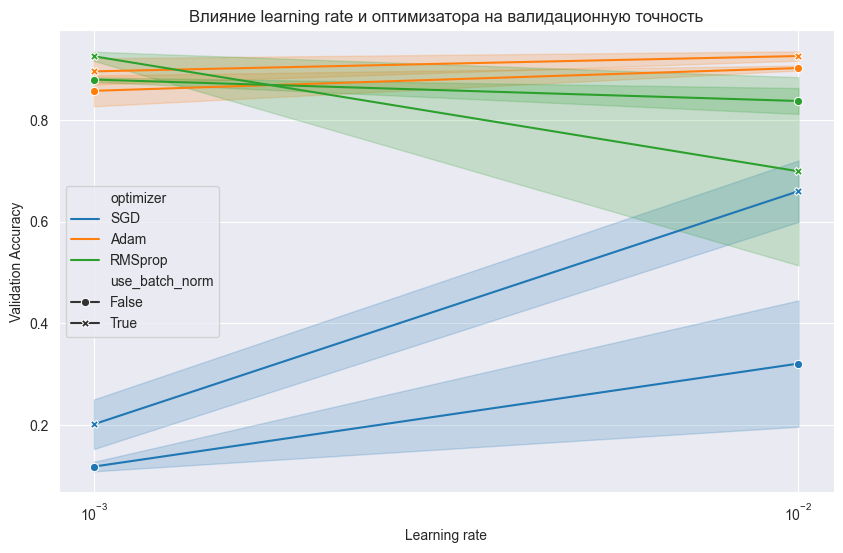

In [25]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=df,
    x="lr",
    y="val_acc",
    hue="optimizer",
    style="use_batch_norm",
    markers=True,
    dashes=False,
)
plt.title("Влияние learning rate и оптимизатора на валидационную точность")
plt.xlabel("Learning rate")
plt.ylabel("Validation Accuracy")
plt.xscale("log")
plt.show()

Сразу видно, что у SGD маленький LR почти не работает (val_acc ~0.1–0.4).
На SGD и Adam влияет в лучшую сторону

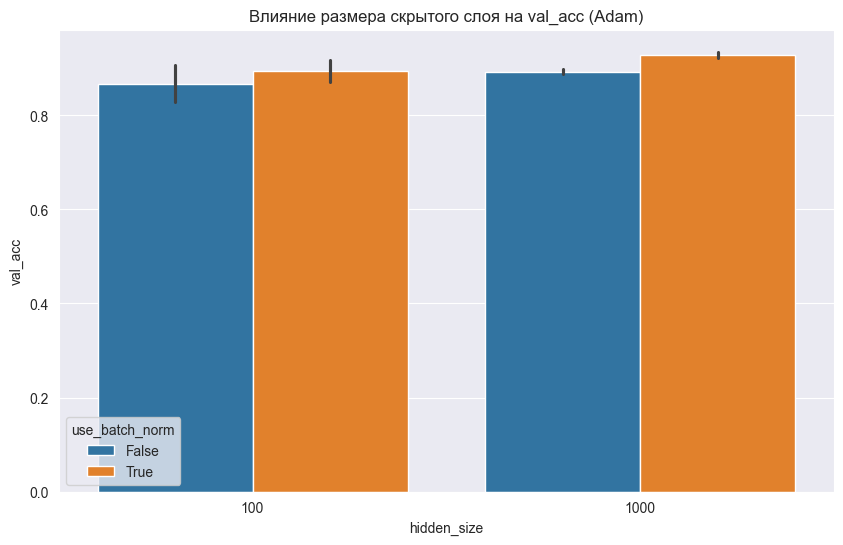

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df[df["optimizer"]=="Adam"],
    x="hidden_size",
    y="val_acc",
    hue="use_batch_norm"
)
plt.title("Влияние размера скрытого слоя на val_acc (Adam)")
plt.show()

Для Adam увеличение hidden_size с 100 → 1000 немного улучшает val_acc, но эффект не критичный.

BatchNorm даёт дополнительный небольшой прирост.

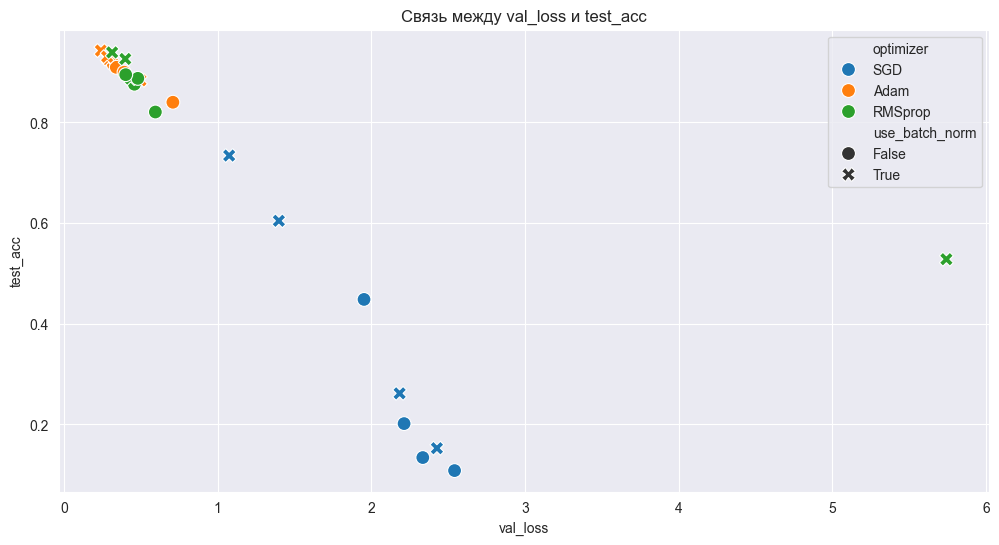

In [27]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df,
    x="val_loss",
    y="test_acc",
    hue="optimizer",
    style="use_batch_norm",
    s=100
)
plt.title("Связь между val_loss и test_acc")
plt.show()

Меньший val_loss почти всегда коррелирует с большим test_acc.

In [28]:
df_sorted = df.sort_values(by="test_acc", ascending=False)

# вывод топ 10 лучших конфигураций
top_df = df_sorted.head(10)
print(top_df)

   optimizer     lr  hidden_size  use_batch_norm  val_loss   val_acc  test_acc
11      Adam  0.010         1000            True  0.240257  0.935417    0.9426
23   RMSprop  0.001         1000            True  0.313318  0.934667    0.9390
15      Adam  0.001         1000            True  0.280794  0.921667    0.9304
21   RMSprop  0.001          100            True  0.398598  0.916667    0.9260
9       Adam  0.010          100            True  0.289617  0.917000    0.9259
8       Adam  0.010          100           False  0.319943  0.907417    0.9160
10      Adam  0.010         1000           False  0.340269  0.897667    0.9093
14      Adam  0.001         1000           False  0.390859  0.888083    0.8997
22   RMSprop  0.001         1000           False  0.401521  0.884083    0.8947
20   RMSprop  0.001          100           False  0.480268  0.875583    0.8874


Лучшие конфигурации: Adam, lr=0.01, hidden=1000, batch_norm=True (test_acc \~0.943) и RMSprop, lr=0.001, hidden=1000, batch_norm=True (~0.939).